In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Présentation du projet

Projet du cours d'Introduction au Machine Learning pour l'Image (IMLI)<br>
Promo : IMAGE 2025<br>
Enseignants : Guillaume Tochon & Joseph Chazalon

## Chargement et présentation des données

Les données qui sont mises à votre disposition pour ce projet sont celles du [_IEEE GRSS Data Fusion Contest 2013_](http://www.classic.grss-ieee.org/community/technical-committees/data-fusion/2013-ieee-grss-data-fusion-contest/). Le Data Fusion Contest de l'IEEE GRSS (Geoscience and Remote Sensing Society) est un challenge organisé chaque année par les membres du chapitre GRSS de l'association IEEE, qui est ouvert à tout chercheur, doctorant, étudiant, etc., et qui met en oeuvre des problématiques de fusion d'information (multi-capteurs, multi-dates, multi-sites, etc.) pour des applications en télédétection (imagerie satellitaire).

Les données du projet, présentées ci-dessous, ont été acquises au dessus de l'université de Houston en 2012, et se composent d'une image hyperpsectale de 144 bandes couvrant la portion $380-1050~$nm du spectre éléctromagnétique, et d'une image LiDAR. Les deux images sont à la même résolution spatiale de 2.5 m/pixel, et sont co-registrées (chaque pixel de l'une couvre exactement la même surface au sol que le pixel correspondant de l'autre image).

### Téléchargement et extraction des données

In [2]:
%%bash
if [ -d "data" ]; then
    echo "Le dossier data existe déjà"
else
    mkdir -p "data"
    wget -q "https://www.lrde.epita.fr/~gtochon/IML/data.zip" -P "data"
    unzip -q "data/*.zip" -d "data"
    rm "data/"*.zip*
fi

### Image LIDAR ([plus d'infos ici](https://fr.wikipedia.org/wiki/Lidar))

Une image acquise par un capteur LiDAR fournit un modèle d'élévation de terrain (DSM, pour _digital surface model_). La scène est illuminée par un laser, et le capteur mesure le délai nécessaire à l'écho laser pour revenir depuis la cible. Connaissant la vitesse de déplacement du laser (vitesse de la lumière) et le temps nécessaire au laser pour faire l'aller/retour jusqu'à la scène, on peut en déduire facilement la distance. Lorsque le capteur LiDAR est embarqué sur un avion, la connaissance supplémentaire de l'altitude de vol de l'avion permet d'en déduire au final la hauteur du terrain (normalisée par rapport à une hauteur 0 fixée de manière arbitraire) : plus la valeur d'un pixel est élevée dans l'image LiDAR, plus la zone au sol correpondante est haute.

In [3]:
lidar = np.load("data/lidar.npy")
print(
    "L'image LiDAR est composée de %d lignes et %d colonnes " % (lidar.shape)
    + "au format %s" % lidar.dtype
)

L'image LiDAR est composée de 349 lignes et 1905 colonnes au format float32


#### Visualisation du LiDAR

In [4]:
print(
    "Valeur min = %1.3f et valeur max = %1.3f dans l'image LiDAR"
    % (lidar.min(), lidar.max())
)

Valeur min = 4.420 et valeur max = 70.852 dans l'image LiDAR


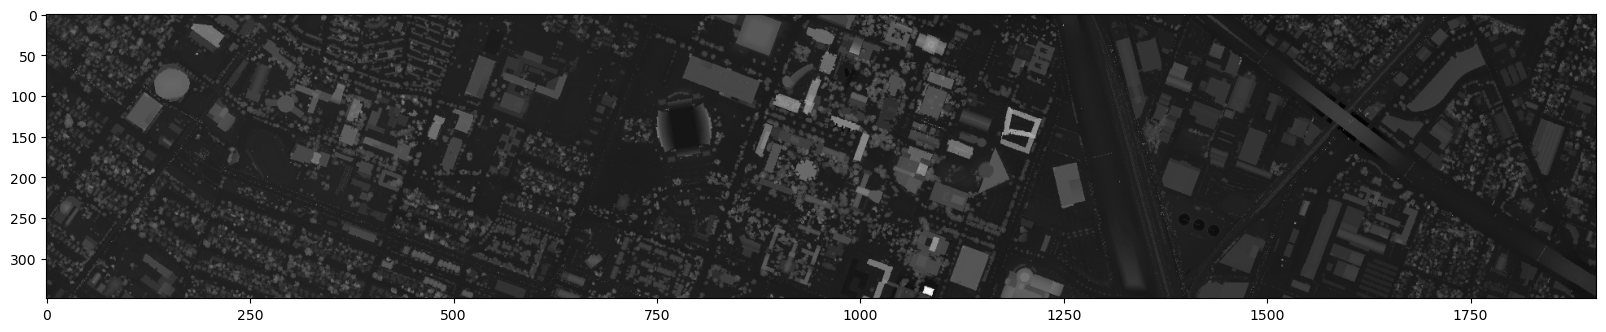

In [9]:
plt.figure(figsize=(20, 5))
plt.imshow(lidar, cmap="gray")
plt.show()

### Image hyperspectrale ([plus d'infos ici](https://fr.wikipedia.org/wiki/Imagerie_hyperspectrale))

Les images hyperspectrales sont des "extensions" des images RGB traditionnelles dans le sens où elles n'ont plus 3 canaux, mais des centaines (voire des milliers). 
Un capteur hyperspectral échantillonne finement le spectre électromagnétique en collectant la quantité de lumière reçue dans de fines bandes de longueur d'onde (typiquement, une bande spectrale correspond a une largeur de quelques nanomètres). Au final, on obtient un cube de données avec $N$ canaux, et un pixel $\mathbf{x}$ n'est plus un triplet $\mathbf{x} = [x_R, x_G, x_B]$ comme pour une image RGB, mais un $N$-uplet $\mathbf{x} = [x_1,\dots,x_N] \in \mathbb{R}^N$ où chaque valeur $x_i$ correspond à la quantité de lumière qui a été reçue dans la $i$ème bande. Comme chaque bande est associée à une longueur d'onde particulière dans le spectre électromagnétique, tracer $\mathbf{x}$ en fonction de $i$ donne un _spectre de réflectance,_ en d'autres termes, comment la lumière qui atteint le capteur a interagi avec la matière dans la scène imagée. Comme deux matériaux différents (par exemple la végétation et le bitume) n'interagissent pas de la même manière avec la lumière, une image hyperspectrale permet d'identifier les composants macroscopiques (végétation, terre, métal, béton, eau, etc) présents dans la scène imagée. Les capteurs hyperspectraux sont largement utilisés dans le domaine de l'imagerie satellitaire (embarqués dans des avions et des satellites) à des fins d'observation de la Terre.

In [5]:
hsi_raw = np.load("data/hyperspectral.npy")
print(
    "L'image hyperspectrale est composée de %d lignes, %d colonnes et %d bandes "
    % (hsi_raw.shape)
    + "au format %s" % hsi_raw.dtype
)

L'image hyperspectrale est composée de 349 lignes, 1905 colonnes et 144 bandes au format uint16


#### Visualisation de l'image hyperspectrale

In [6]:
print(
    "Valeur min = %d et valeur max = %d dans l'image hyperspectrale"
    % (hsi_raw.min(), hsi_raw.max())
)

Valeur min = 0 et valeur max = 65517 dans l'image hyperspectrale


Une image hyperspectrale étant composée de centaines (voir milliers) de bandes, sa visualisation n'est pas directe : on ne peut pas demander à une routine de visualisation d'afficher telle quelle une image hyperspectrale. Il faut au préalable en extraire une version RGB, en sélectionnant 3 bandes spectrales (c'est-à-dire, 3 tranches du cube de données) dont les longueurs d'ondes correspondent à celles du rouge, du vert et du bleu.

Ici, l'intervalle de longueur d'ondes $380-1050~$nm est subdivisé en 144 bandes spectrales, et prenant comme longueurs d'ondes de référence 465 nm pour le bleu, 532 nm pour le vert et 630 nm pour le rouge, on peut calculer les bandes RGB suivantes : R = 54$^e$ bande, G = 32$^e$ bande et B = 18$^e$ bande.

In [7]:
rgb_bands = [54, 32, 18]
hsi_rgb = hsi_raw[:, :, rgb_bands]
hsi_rgb = (
    hsi_rgb / hsi_rgb.max()
)  # normalisation des valeurs dans [0,1] pour l'affichage

In [8]:
# Don't mind me, I'm just here to pimp a little bit the RGB image
pmin, pmax = np.percentile(hsi_rgb, (1, 95), axis=(0, 1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:, :, i] = (hsi_rgb[:, :, i] - pmin[i]) / (pmax[i] - pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped < 0] = 0
hsi_rgb_pimped[hsi_rgb_pimped > 1] = 1

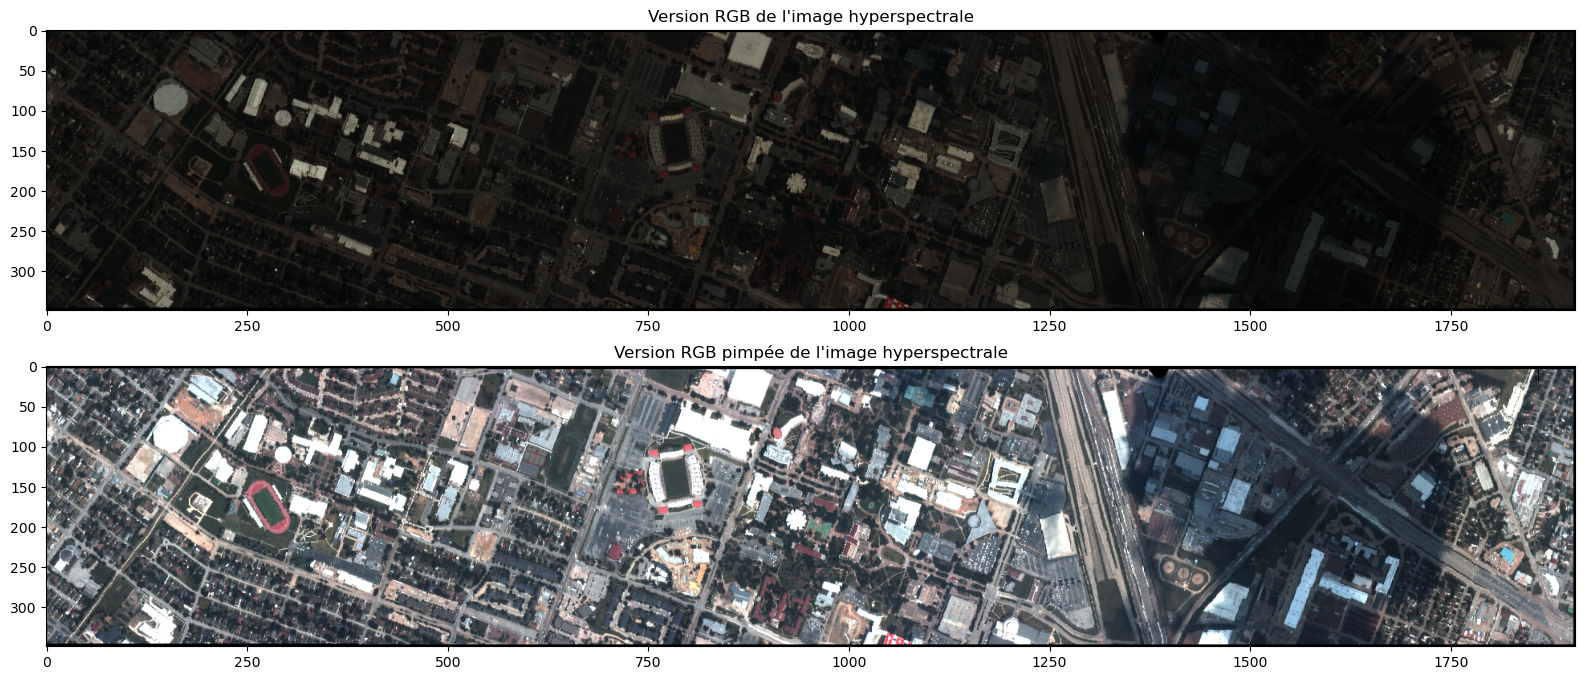

In [16]:
plt.figure(figsize=(20, 8))
plt.subplot(211)
plt.title("Version RGB de l'image hyperspectrale")
plt.imshow(hsi_rgb)
plt.subplot(212)
plt.title("Version RGB pimpée de l'image hyperspectrale")
plt.imshow(hsi_rgb_pimped)
plt.show()

La scène est donc composée majoritairement de structures urbaines (maisons, bâtiments, routes, etc). On peut voir également des structures sportives (stade, piste de running, terrains de tennis). La partie droite de l'image est également assombrie par la présence d'un nuage (non discernable dans le LiDAR, qui est insensible aux artefacts d'illumations).

Pour facilier l'analyse visuelle de la scène, on peut la subdiviser en 3 sous-images correspondant à la partie gauche, à la partie centrale et à la partie droite de la scène. On peut remarquer en particulier une bande noire sur le pourtour de l'image hyperspectrale.

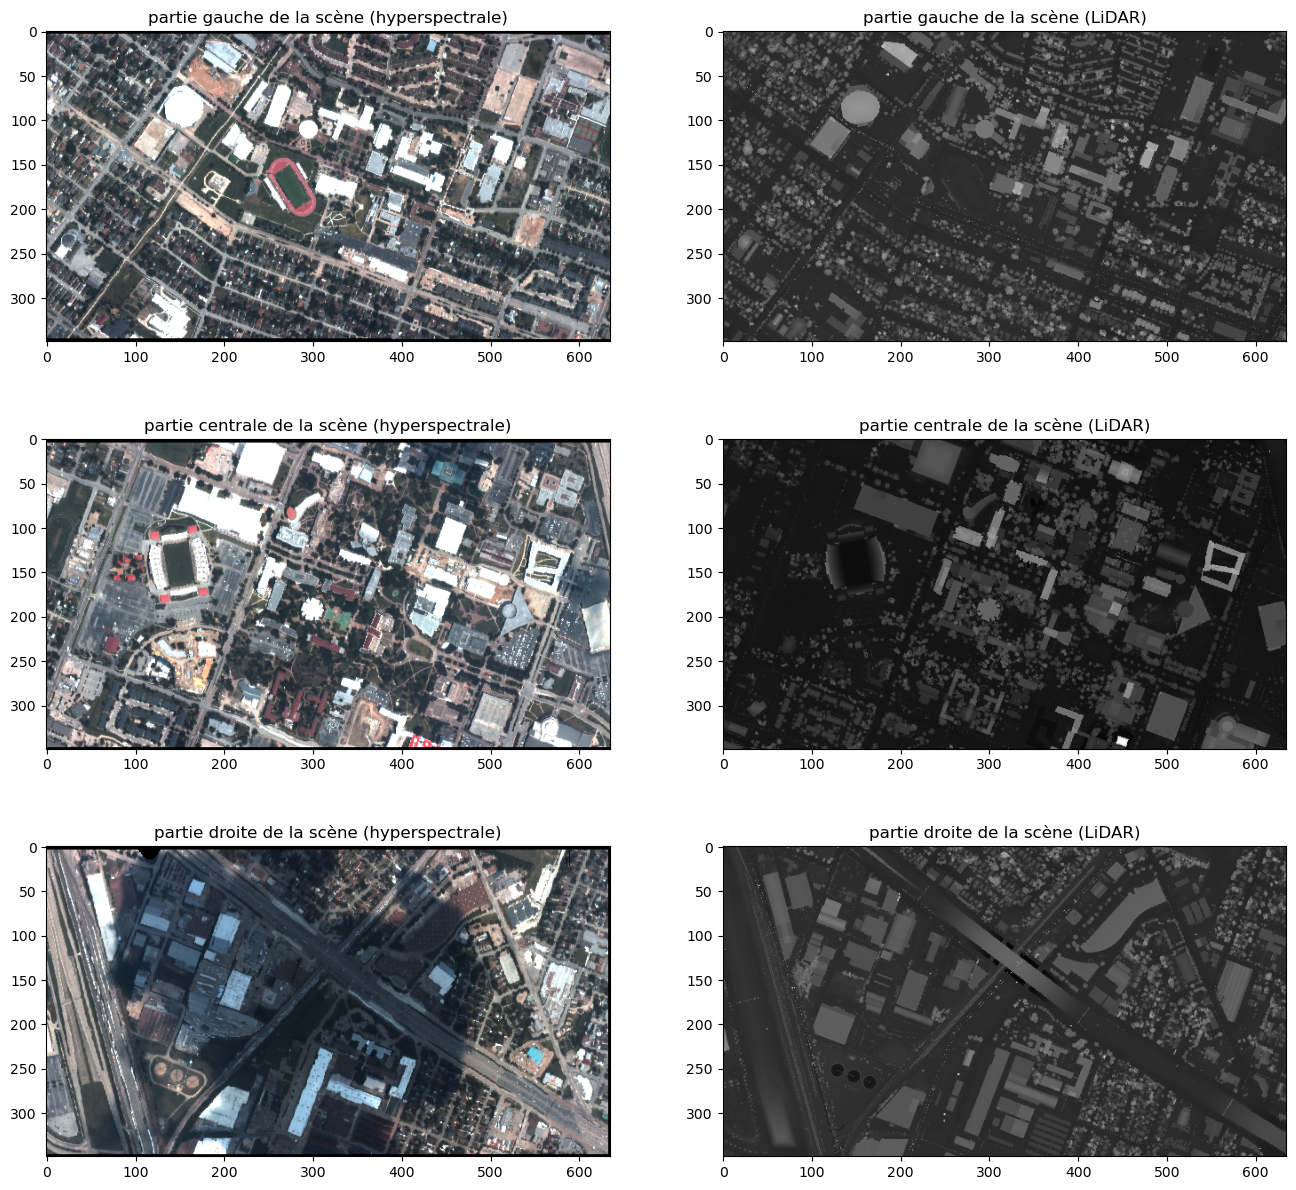

In [17]:
plt.figure(figsize=(16, 15))
plt.subplot(321)
plt.title("partie gauche de la scène (hyperspectrale)")
plt.imshow(hsi_rgb_pimped[:, :635, :])
plt.subplot(322)
plt.title("partie gauche de la scène (LiDAR)")
plt.imshow(lidar[:, :635], cmap="gray")
plt.subplot(323)
plt.title("partie centrale de la scène (hyperspectrale)")
plt.imshow(hsi_rgb_pimped[:, 635:1270, :])
plt.subplot(324)
plt.title("partie centrale de la scène (LiDAR)")
plt.imshow(lidar[:, 635:1270], cmap="gray")
plt.subplot(325)
plt.title("partie droite de la scène (hyperspectrale)")
plt.imshow(hsi_rgb_pimped[:, 1270:, :])
plt.subplot(326)
plt.title("partie droite de la scène (LiDAR)")
plt.imshow(lidar[:, 1270:], cmap="gray")
plt.show()

## Chargement de la vérité terrain

Dans la scène présentée ci-dessus, 15 classes sémantiques ont été définies par les organisateurs du _Data Fusion Contest 2013_, et des zones au sol correspondant à ces différentes classes ont été identifées. Ces différentes zones de références constituent la vérité terrain, dont une partie vous est fournie dans le cadre du projet (la partie manquante, qui vous est cachée, servira de base de test pour la validation de votre solution).

In [9]:
%%bash
if [ -d "groundtruth" ]; then
    echo "Le dossier groundtruth existe déjà"
else
    mkdir -p "groundtruth"
    wget -q "https://www.lrde.epita.fr/~gtochon/IML/groundtruth.zip" -P "groundtruth"
    unzip -q "groundtruth/*.zip" -d "groundtruth"
    rm "groundtruth/"*.zip*
fi

In [10]:
groundtruth = np.load("groundtruth/groundtruth.npy")
groundtruth_info = np.load("groundtruth/groundtruth_info.npy", allow_pickle=True)
groundtruth_rgb = plt.imread("groundtruth/groundtruth.png")

La vérité terrain qui vous est fournie dans le cadre du projet est composée de trois fichiers : 
* `groundtruth_info` : un récapitulatif des différentes classes sémantiques (numérotées de 1 à 15) 

In [11]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0])},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0])},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87])},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0])},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45])},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255])},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255])},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216])},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0])},
       {'class_name': 'highway', 'class_label': 10, 'class_color': array([139,   0,   0])},
       {'class_name': 'railway', 'class_label': 11, 'class_color': array

Chaque classe est composée d'environ $190$ pixels (ce qui est peu...)

In [12]:
for ii in range(15):
    print(
        "Classe %d : %s (%d pixels au total)"
        % (ii + 1, groundtruth_info[ii]["class_name"], (groundtruth == ii + 1).sum())
    )

Classe 1 : grass_healthy (198 pixels au total)
Classe 2 : grass_stressed (190 pixels au total)
Classe 3 : grass_synthetic (192 pixels au total)
Classe 4 : tree (188 pixels au total)
Classe 5 : soil (186 pixels au total)
Classe 6 : water (182 pixels au total)
Classe 7 : residential (196 pixels au total)
Classe 8 : commercial (191 pixels au total)
Classe 9 : road (193 pixels au total)
Classe 10 : highway (191 pixels au total)
Classe 11 : railway (181 pixels au total)
Classe 12 : parking_lot1 (192 pixels au total)
Classe 13 : parking_lot2 (184 pixels au total)
Classe 14 : tennis_court (181 pixels au total)
Classe 15 : running_track (187 pixels au total)


* `groundtruth` : la position spatiale dans la scène des différents pixels appartenant à ces 15 classes thématiques. Chaque pixel appartenant à la i$^e$ classe est donc de valeur $i$ dans cette carte de vérité terrain (par convention, tous les pixels dont la classe est inconnue sont de valeur $0$).

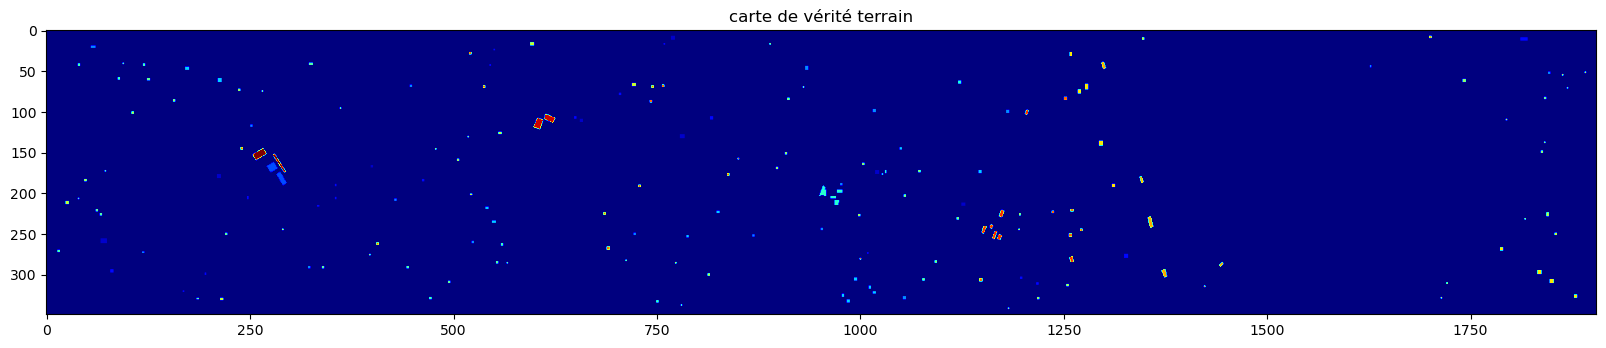

In [22]:
plt.figure(figsize=(20, 5))
plt.title("carte de vérité terrain")
plt.imshow(groundtruth, cmap="jet")
plt.show()

* `groundtruth.png` : pour faciliter la visualisation des différentes classes composant la vérité terrain, on peut également attribuer à chaque classe une couleur (arbitraire), et représenter la vérité terrain comme une image RGB.

In [111]:
cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii["class_color"])
cls_rgb = np.array(cls_rgb).reshape(15, -1, 3)
cls_rgb

array([[[  0, 205,   0]],

       [[127, 255,   0]],

       [[ 46, 205,  87]],

       [[  0, 139,   0]],

       [[160,  82,  45]],

       [[  0, 255, 255]],

       [[255, 255, 255]],

       [[216, 191, 216]],

       [[255,   0,   0]],

       [[139,   0,   0]],

       [[100, 100, 100]],

       [[255, 255,   0]],

       [[238, 154,   0]],

       [[ 85,  26, 139]],

       [[255, 127,  80]]])

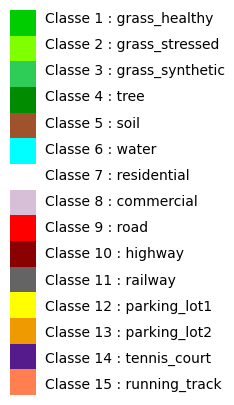

In [24]:
plt.figure(figsize=(5, 5))
plt.imshow(cls_rgb)
plt.axis("off")
for cls in range(15):
    plt.text(
        0.85,
        1.02 * cls,
        "Classe %d : %s" % (cls + 1, groundtruth_info[cls]["class_name"]),
    )
plt.show()

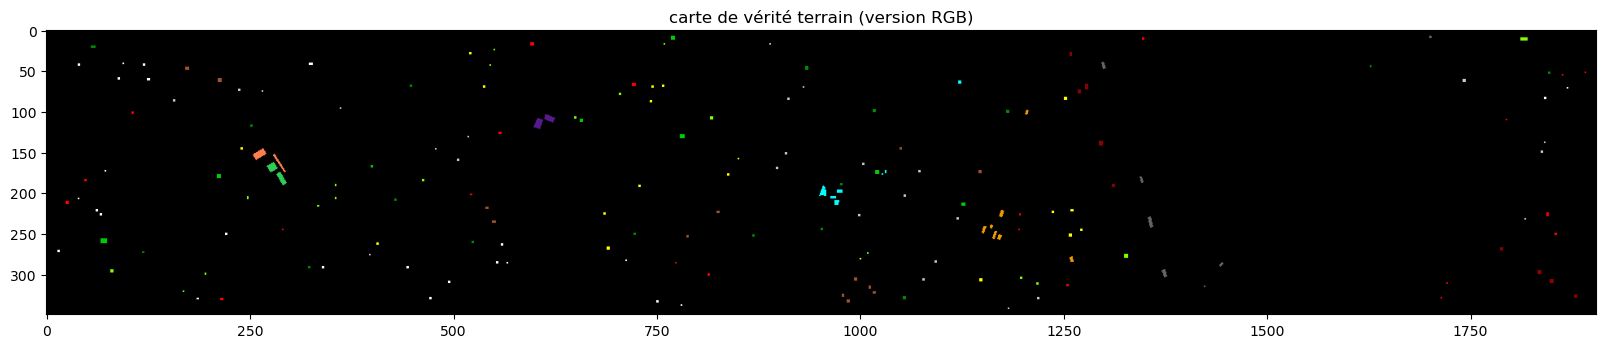

In [25]:
plt.figure(figsize=(20, 5))
plt.title("carte de vérité terrain (version RGB)")
plt.imshow(groundtruth_rgb)
plt.show()

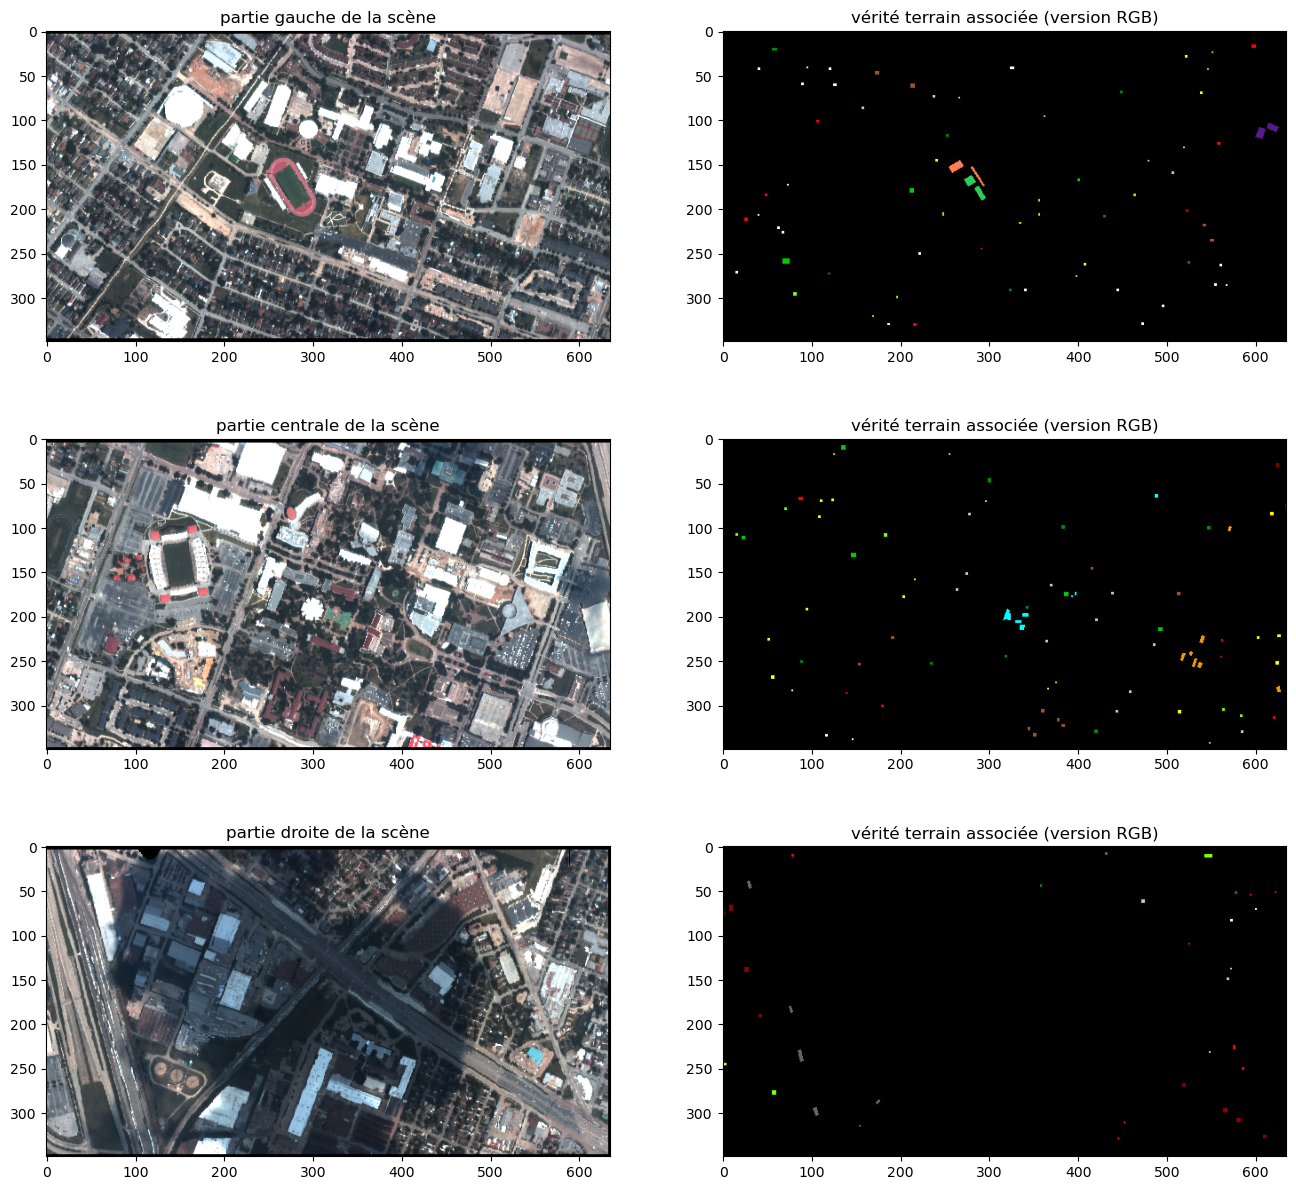

In [26]:
plt.figure(figsize=(16, 15))
plt.subplot(321)
plt.title("partie gauche de la scène")
plt.imshow(hsi_rgb_pimped[:, :635, :])
plt.subplot(322)
plt.title("vérité terrain associée (version RGB)")
plt.imshow(groundtruth_rgb[:, :635, :], cmap="gray")
plt.subplot(323)
plt.title("partie centrale de la scène")
plt.imshow(hsi_rgb_pimped[:, 635:1270, :])
plt.subplot(324)
plt.title("vérité terrain associée (version RGB)")
plt.imshow(groundtruth_rgb[:, 635:1270, :], cmap="gray")
plt.subplot(325)
plt.title("partie droite de la scène")
plt.imshow(hsi_rgb_pimped[:, 1270:, :])
plt.subplot(326)
plt.title("vérité terrain associée (version RGB)")
plt.imshow(groundtruth_rgb[:, 1270:, :], cmap="gray")
plt.show()

## Objectif du projet

L'objectif du projet est d'effectuer **la classification sémantique des pixels de la scène**, c'est-à-dire assigner à chaque pixel l'identifiant (entre 1 et 15) de la classe à laquelle il appartient. Par exemple, tous les pixels de maison doivent être assignés à la classe $7$ (`residential`), tous les pixels de route doivent être assignés à la classe $9$ (`road`), etc.

Les images hyperspectrales (réflectance) et LiDAR (hauteur) portent une information complémentaire car de nature physique différente. Deux zones adjacentes dans la scène peuvent avoir des réponses spectrales très proches (par exemple, de la végétation et de l'herbe), mais des hauteurs différentes dans le LiDAR. À l'inverse, deux zones adjacentes peuvent avoir des hauteurs identiques dans l'image LiDAR (par exemple, de l'herbe et de la route) mais des réponses spectrales très différentes. Ainsi, votre solution devra, d'une manière ou d'une autre, fusionner l'information issue de l'image LiDAR avec celle de l'image hyperspectrale.

Votre solution devra prendre en entrée les deux images (hyperspectrale et LiDAR) et produire en sortie une carte de classification thématique, où chaque pixel a pour valeur le numéro de la classe à laquelle il appartient. Vous pouvez vous servir de toutes les ressources disponibles dans les bibliothèques `scikit-learn`, `scikit-image`, `numpy` et `scipy`, ainsi que de vos connaissances en traitement d'image (pour par exemple pré-traiter les données d'une manière ou d'une autre, ou post-traiter le résultat de classification).

Votre notebook devra :

- contenir votre code et toutes les explications qui nous permettront de comprendre et valider votre démarche
- exporter votre prédiction finale sur toute l'image au format `.npy` (voir ci-après) dans le même format que la vérité terrain
- préciser la contribution de chaque membre du groupe.

<u> pro tip </u> : une image hyperspectrale est nativement représentée comme un cube de données de dimensions $r \times c \times N$ où $r$ et $c$ correspondent au nombre de lignes et de colonnes dans l'image, et $N$ est le nombre de canaux, ce qui ne correspond pas au format attendu par la plupart des algorithmes de `scikit-image` ($N_{samples} \times N_{features}$, où $N_{samples}$ est le nombre d'échantillons et $N_{features}$ est le nombre de caractéristiques (la dimensionalité) de chaque échantillon). 
<br> Pour transformer une image hyperspectrale au format standard de `scikit-image`, on pourra simplement utiliser `hsi.reshape(rc,N)`

## Export des résultats

Nous vous fournissons ici le code pour exporter vos résultats au bon format.

Il vous suffit d'utiliser la fonction `export_predictions()` ci-dessous, en vous assurant qu'elle ne renvoie pas d'erreurs.

In [27]:
def export_predictions(predictions: np.array, filename: str):
    """
    Exporte les prédictions dans un fichier NPZ.
    :param predictions: np.array de shape (349, 1905) et de dtype uint8 contenant les prédictions
    :param filename: nom du fichier de sortie
    """
    # Check we have the right shape and dtype
    if predictions.shape != (349, 1905):
        raise ValueError("Les prédictions doivent être de shape (349, 1905)")
    if predictions.dtype != np.uint8:
        raise ValueError("Les prédictions doivent être de dtype uint8")
    # Check predictions are in the correct domain
    if np.any(predictions > 15):
        raise ValueError("Les prédictions doivent être dans l'intervalle [0, 15]")
    # Ensure the output file has the right extension
    if not filename.endswith(".npz"):
        filename += ".npz"
    # Save the predictions
    np.savez_compressed(filename, predictions=predictions)
    # Remind students to submit the file
    print(
        f"Prédictions exportées dans {filename}, n'oubliez pas d'envoyer votre fichier !"
    )

In [28]:
# Exemples d'exports
predictions_random = np.random.randint(0, 16, size=(349, 1905), dtype=np.uint8)
export_predictions(predictions_random, "predictions_random.npz")

predictions_ones = np.ones((349, 1905), dtype=np.uint8)
export_predictions(predictions_ones, "predictions_ones.npz")

predictions_gt = groundtruth
export_predictions(predictions_gt, "predictions_groundtruth.npz")

Prédictions exportées dans predictions_random.npz, n'oubliez pas d'envoyer votre fichier !
Prédictions exportées dans predictions_ones.npz, n'oubliez pas d'envoyer votre fichier !
Prédictions exportées dans predictions_groundtruth.npz, n'oubliez pas d'envoyer votre fichier !


Voici également une fonction qui vous permet d'évaluer la performance de votre approche par rapport à une cible attendue.
Dans votre cas, vous n'aurez pas accès à la vérité terrain sur le jeu de test mais :
- vous pouvez (devez ?) tester la performance de votre approche sur le jeu d'entraînement (et sur d'éventuels jeux de validation que vous pourriez définir)
- vous avez accès au code d'évaluation que nous utiliserons pour évaluer la performance de votre approche

In [29]:
def eval_performance_raw(predictions: np.array, targets: np.array):
    """Evalue la performance de l'algorithme de classification.

    Args:
        predictions (np.array): prédictions
        targets (np.array): valeurs attendues (vérité terrain)
    """
    # Check we have the right shape and dtype
    if predictions.shape != (349, 1905):
        raise ValueError("Les prédictions doivent être de shape (349, 1905)")
    if predictions.dtype != np.uint8:
        raise ValueError("Les prédictions doivent être de dtype uint8")
    if targets.shape != (349, 1905):
        raise ValueError("Les cibles doivent être de shape (349, 1905)")
    if targets.dtype != np.uint8:
        raise ValueError("Les cibles doivent être de dtype uint8")
    # Check predictions are in the correct domain
    if np.any(predictions > 15):
        raise ValueError("Les prédictions doivent être dans l'intervalle [0, 15]")
    if np.any(targets > 15):
        raise ValueError("Les cibles doivent être dans l'intervalle [0, 15]")
    # Compute the confusion matrix
    confusion_matrix = np.zeros((16, 16), dtype=np.int32)
    for i in range(16):
        for j in range(16):
            confusion_matrix[i, j] = np.sum((predictions == i) & (targets == j))
    # Compute the overall accuracy
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)
    # Compute the class-wise accuracy
    class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    # Accuracy ignoring the unclassified pixels in the ground truth
    mask = targets != 0
    accuracy_no_unclassified = np.sum(predictions[mask] == targets[mask]) / np.sum(mask)
    # Return the results
    return accuracy, class_accuracy, accuracy_no_unclassified, confusion_matrix

In [30]:
def load_eval_perf(filename: str, targets: np.array):
    """
    Charge les prédictions depuis un fichier NPZ et évalue la performance de l'algorithme de classification.

    Args:
        filename (str): nom du fichier NPZ contenant les prédictions
        targets (np.array): valeurs attendues (vérité terrain)
    """
    # Load the predictions
    predictions = np.load(filename)["predictions"]
    # Evaluate the performance
    return eval_performance_raw(predictions, targets)

Évaluation de predictions_ones.npz:
Mean accuracy (micro, no background): 0.07
Mean accuracy (macro, no background): nan


/tmp/ipykernel_9095/3770553655.py:30: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)


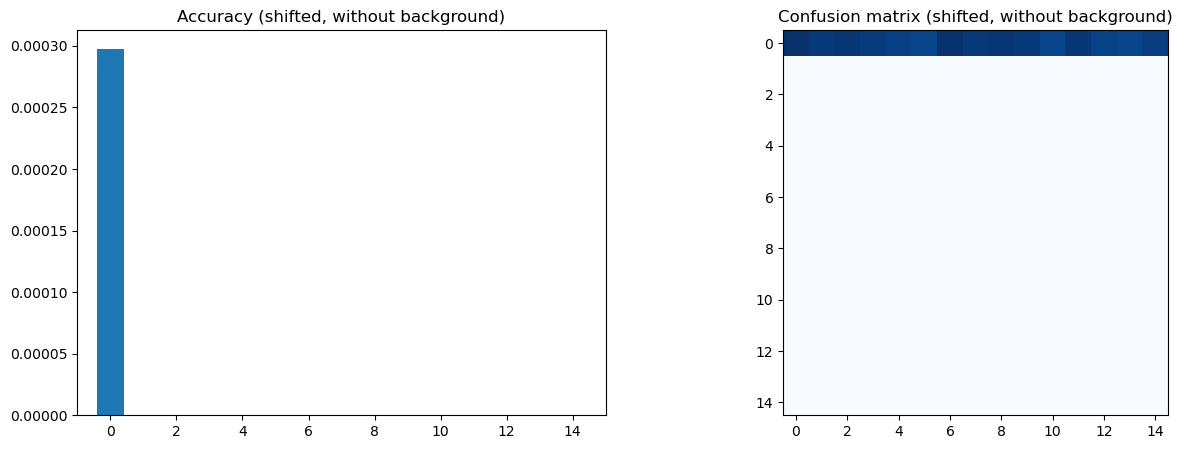

Évaluation de predictions_random.npz:
Mean accuracy (micro, no background): 0.06
Mean accuracy (macro, no background): 0.00


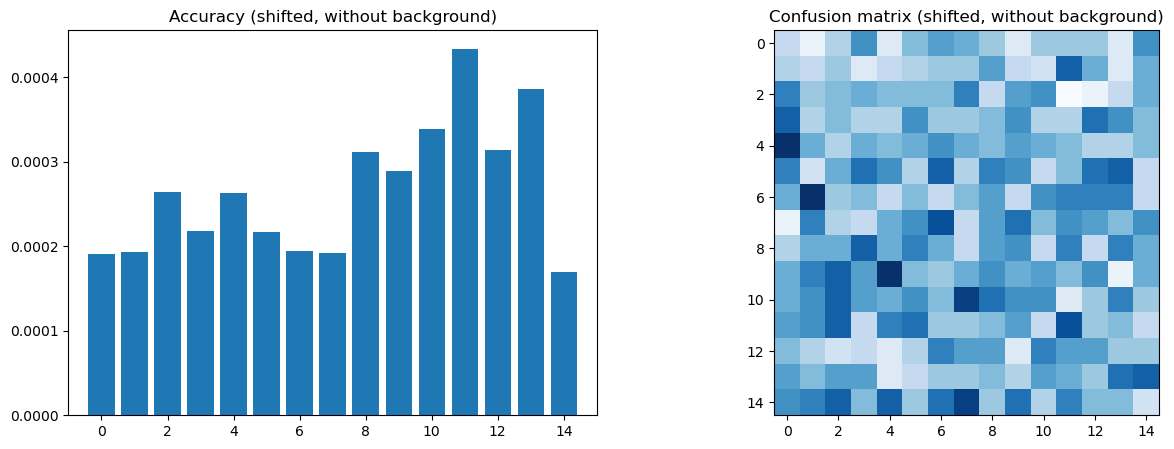

Évaluation de predictions_groundtruth.npz:
Mean accuracy (micro, no background): 1.00
Mean accuracy (macro, no background): 1.00


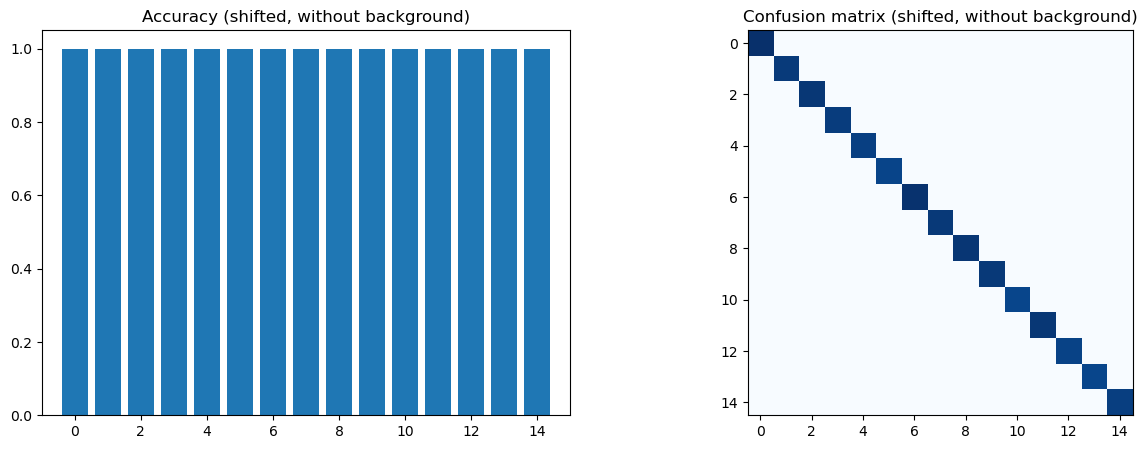

In [31]:
# Exemples d'évaluation
import glob

prediction_files = glob.glob("predictions_*.npz")
groundtruth = np.load("groundtruth/groundtruth.npy")
for file in prediction_files:
    print(f"Évaluation de {file}:")
    accuracy, class_accuracy, accuracy_no_unclassified_micro, confusion_matrix = (
        load_eval_perf(file, groundtruth)
    )
    print(f"Mean accuracy (micro, no background): {accuracy_no_unclassified_micro:.2f}")
    accuracy_no_unclassified_macro = np.mean(class_accuracy[1:])
    print(f"Mean accuracy (macro, no background): {accuracy_no_unclassified_macro:.2f}")
    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.title("Accuracy (shifted, without background)")
    plt.bar(range(15), class_accuracy[1:])
    plt.xlim(-1, 15)
    plt.subplot(122)
    plt.title("Confusion matrix (shifted, without background)")
    plt.imshow(confusion_matrix[1:, 1:], cmap="Blues")
    plt.show()

# À vous de jouer !

### How much groundtruth data we have ? Is it balanced ?

In [33]:
__labels, __counts = np.unique(groundtruth, return_counts=True)

for label, count in zip(__labels, __counts):
    print(f"{label}: {count} ~= {round(count / groundtruth.size * 100, 2)}%")
print(f"\nTotal: {groundtruth.size}")

0: 662013 ~= 99.57%
1: 198 ~= 0.03%
2: 190 ~= 0.03%
3: 192 ~= 0.03%
4: 188 ~= 0.03%
5: 186 ~= 0.03%
6: 182 ~= 0.03%
7: 196 ~= 0.03%
8: 191 ~= 0.03%
9: 193 ~= 0.03%
10: 191 ~= 0.03%
11: 181 ~= 0.03%
12: 192 ~= 0.03%
13: 184 ~= 0.03%
14: 181 ~= 0.03%
15: 187 ~= 0.03%

Total: 664845


### Data

In [67]:
# vectorize
hsi_reshaped = hsi_raw.reshape(-1, hsi_raw.shape[-1])
lidar_flatten = lidar.reshape(-1)
groundtruth_flatten = groundtruth.reshape(-1)

# compute labeled data
idx = groundtruth_flatten.nonzero()[0]

### Display for each class the histogram of lidar values

In [63]:
_N_CLASSES = 15
_PER_ROW = 3


def _lidar_histograms(lidars):
    n_classes = len(lidars)
    assert n_classes == _N_CLASSES
    n_rows = (n_classes - 1) // _PER_ROW + 1
    maxfreq = max(max(np.histogram(lidar, bins=20)[0]) for lidar in lidars)
    maxdist = max(max(lidar) for lidar in lidars)
    fig, axs = plt.subplots(
        n_rows, _PER_ROW, figsize=(15, 5 * n_rows), constrained_layout=True
    )

    fig.suptitle("Distance Distribution for Classes")

    for ii, lidar in enumerate(lidars):
        ax = axs[ii // _PER_ROW, ii % _PER_ROW] if len(axs.shape) > 1 else axs[ii]
        ax.hist(lidar, bins=20, alpha=0.5)
        ax.set_title(f"Class {ii+1} {groundtruth_info[ii]['class_name']}")
        ax.set_ylabel("Counts")
        ax.set_xlabel("Distance")
        # ax.set_ylim(0, maxfreq + 1)
        ax.set_xlim(0, maxdist + 1)

    plt.show()

In [ ]:
__lidar_labeled = lidar_flatten[idx]
__labeled_labels = groundtruth_flatten[idx]
__lidars = [__lidar_labeled[__labeled_labels == (ii + 1)] for ii in range(_N_CLASSES)]
_lidar_histograms(__lidars)

### Dimension Reduction via PCA

In [81]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [72]:
# normalize hsi
__hsi_scaled = StandardScaler().fit_transform(hsi_reshaped)

# reduce hsi to 2 features
__pca = PCA(n_components=2, random_state=42)
hsi_reduced = __pca.fit_transform(__hsi_scaled)

### Create Dataset

In [83]:
from sklearn.model_selection import StratifiedShuffleSplit

In [121]:
__hsi_reduced_labeled_features = hsi_reduced[idx]
__hsi_reshaped_labeled_features = hsi_reshaped[idx]
__lidar_labeled = lidar_flatten[idx].reshape(-1, 1)

# naive approach is to concat lidar to hsi features
X = np.hstack((__hsi_reshaped_labeled_features, __lidar_labeled))
y = groundtruth_flatten[idx]

sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
__train_idx, __test_idx = next(sss.split(X, y))
X_train, y_train = X[__train_idx], y[__train_idx]
X_test, y_test = X[__test_idx], y[__test_idx]

### Simple Pipeline

In [105]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

In [122]:
pipeline = make_pipeline(
    StandardScaler(),
    SGDClassifier(
        random_state=42,
        shuffle=False,
        early_stopping=True,
        n_jobs=4,
    ),
)

In [123]:
%%time
pipeline.fit(X_train, y_train)

CPU times: user 347 ms, sys: 953 ms, total: 1.3 s
Wall time: 81.6 ms


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(early_stopping=True, n_jobs=4, random_state=42,
                               shuffle=False))])

In [124]:
pipeline.score(X_test, y_test)

0.7195767195767195

### Color Map

In [109]:
from matplotlib.colors import ListedColormap

In [112]:
cmap = ListedColormap(cls_rgb / 255)

### Classify full image

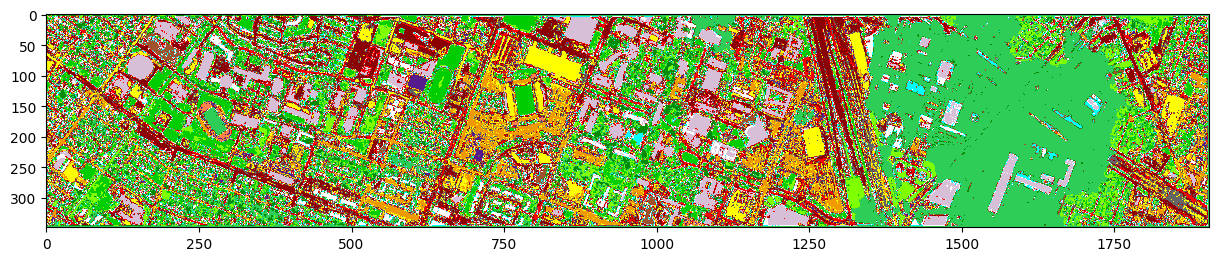

In [125]:
__img = np.hstack((hsi_reshaped, lidar.reshape(-1, 1)))
y_pred = pipeline.predict(__img)
y_pred = y_pred.reshape(lidar.shape)

plt.figure(figsize=(15, 15))
plt.imshow(y_pred, cmap=cmap)